In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os.path
import numpy as np
from tqdm.notebook import tqdm
import pathlib

In [2]:
# need to modify depending on where the notebook is 
image_folder_path = "In-shop Clothes Retrieval Benchmark/Img/"
segmentation_image_folder_path = "In-shop Clothes Retrieval Benchmark/Anno/Segmentation/img_highres_seg/"

### Get data

In [3]:
img_path_df = pd.read_csv('In-shop Clothes Retrieval Benchmark/Anno/list_bbox_inshop.txt',sep="\s+",skiprows=[0], header=0)

### Add high_resolution_name, high_resolution_segmentation_name and segmentation column

In [4]:
img_path_df["high_resolution_name"] = [ segmentation_image_folder_path +  "/".join(image_path.split("/")[1:]) for image_path in img_path_df["image_name"].tolist() ]
img_path_df["high_resolution_segmentation_name"] = [ image_path.split(".")[0] + "_segment.png" for image_path in img_path_df["high_resolution_name"].tolist() ]
img_path_df["segmentation"] = [ os.path.os.path.exists(high_resolution_segmentation_name) for high_resolution_segmentation_name in img_path_df["high_resolution_segmentation_name"].tolist() ]

In [5]:
len(img_path_df)

52712

In [6]:
img_path_df.head(2)

,image_name,clothes_type,pose_type,x_1,y_1,x_2,y_2,high_resolution_name,high_resolution_segmentation_name,segmentation
0,img/WOMEN/Blouses_Shirts/id_00000001/02_1_fron...,1,1,50,49,208,235,In-shop Clothes Retrieval Benchmark/Anno/Segme...,In-shop Clothes Retrieval Benchmark/Anno/Segme...,True
1,img/WOMEN/Blouses_Shirts/id_00000001/02_2_side...,1,2,119,48,136,234,In-shop Clothes Retrieval Benchmark/Anno/Segme...,In-shop Clothes Retrieval Benchmark/Anno/Segme...,True


### Get image with segmentation and front body

In clothes type, "1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes

In pose type, "1" represents frontal view, "2" represents side view, "3" represents back view, "4" represents zoom-out view, "5" represents zoom-in view, "6" represents stand-alone view;

In [7]:
segmented_img_df = img_path_df[(img_path_df["segmentation"]==True)]
print(len(segmented_img_df))
segmented_img_df.head(2)

13752


,image_name,clothes_type,pose_type,x_1,y_1,x_2,y_2,high_resolution_name,high_resolution_segmentation_name,segmentation
0,img/WOMEN/Blouses_Shirts/id_00000001/02_1_fron...,1,1,50,49,208,235,In-shop Clothes Retrieval Benchmark/Anno/Segme...,In-shop Clothes Retrieval Benchmark/Anno/Segme...,True
1,img/WOMEN/Blouses_Shirts/id_00000001/02_2_side...,1,2,119,48,136,234,In-shop Clothes Retrieval Benchmark/Anno/Segme...,In-shop Clothes Retrieval Benchmark/Anno/Segme...,True


In [8]:
full_body_img_df = segmented_img_df[segmented_img_df["pose_type"]==1]
print(len(full_body_img_df))
full_body_img_df.head(2)

7379


,image_name,clothes_type,pose_type,x_1,y_1,x_2,y_2,high_resolution_name,high_resolution_segmentation_name,segmentation
0,img/WOMEN/Blouses_Shirts/id_00000001/02_1_fron...,1,1,50,49,208,235,In-shop Clothes Retrieval Benchmark/Anno/Segme...,In-shop Clothes Retrieval Benchmark/Anno/Segme...,True
4,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,3,1,65,45,233,252,In-shop Clothes Retrieval Benchmark/Anno/Segme...,In-shop Clothes Retrieval Benchmark/Anno/Segme...,True


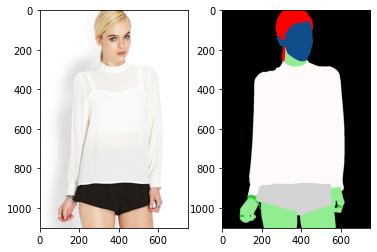

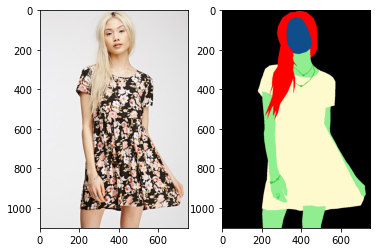

In [9]:
for i in range(2):
    high_resolution_image_image = cv2.imread(full_body_img_df["high_resolution_name"].iloc[i])
    high_resolution_segmentation_image = cv2.imread(full_body_img_df["high_resolution_segmentation_name"].iloc[i])
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(high_resolution_image_image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(high_resolution_segmentation_image, cv2.COLOR_BGR2RGB))
    plt.show()

### Segmentation 

In [10]:
def create_masks(img):
    # verified 
    pants_mask = cv2.inRange(img, (211,211,211), (211,211,211))
    top_mask = cv2.inRange(img, (255,250,250), (255,250,250))
    hair_mask = cv2.inRange(img, (255,0,0), (255,0,0))
    headwear_mask = cv2.inRange(img, (127,255,212), (127,255,212))
    face_mask = cv2.inRange(img, (16,78,139), (16,78,139))
    dress_mask = cv2.inRange(img, (255,250,205), (255,250,205))
    neckwear_mask = cv2.inRange(img, (50,205,50), (50,205,50))
    skirt_mask = cv2.inRange(img, (250,235,215), (250,235,215))
    dress_bis_mask = cv2.inRange(img, (220,220,220), (220,220,220))
    belt_mask = cv2.inRange(img, (255,255,0), (255,255,0))

    # not verified
    leggings_mask = cv2.inRange(img, (70,130,180), (70,130,180))
    eyeglass_mask = cv2.inRange(img, (127,255,212), (127,255,212))
    bag_mask = cv2.inRange(img, (50,205,50), (50,205,50))
    
    # useful masks 
    # verified
    background_mask = cv2.inRange(img, (0,0,0), (0,0,0))
    footwear_mask = cv2.inRange(img,(245,222,179),(245,222,179))
    skin_mask = cv2.inRange(img, (144,238,144), (144,238,144))

    #head_mask = hair_mask + face_mask + headwear_mask + eyeglass_mask
    head_mask = hair_mask + face_mask
    # easy way
    apparel_mask = cv2.bitwise_not(background_mask+skin_mask+footwear_mask+head_mask)
     
    return head_mask, footwear_mask, skin_mask, apparel_mask, background_mask

def show_masks(img,seg_img):
    head_mask, footwear_mask, skin_mask, apparel_mask, background_mask = create_masks(seg_img)
    # without skin
    chosen_mask = head_mask + footwear_mask + apparel_mask
    result = cv2.bitwise_and(img, img, mask=chosen_mask)
    plt.subplot(1, 2, 1)
    plt.imshow(chosen_mask, cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.show()
    # with skin
    chosen_mask = head_mask + footwear_mask + skin_mask + apparel_mask
    result = cv2.bitwise_and(img, img, mask=chosen_mask)
    plt.subplot(1, 2, 1)
    plt.imshow(chosen_mask, cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.show()
    # apparel
    chosen_mask = apparel_mask
    result = cv2.bitwise_and(img, img, mask=chosen_mask)
    plt.subplot(1, 2, 1)
    plt.imshow(chosen_mask, cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.show()
    # head_foot
    chosen_mask = head_mask + footwear_mask
    result = cv2.bitwise_and(img, img, mask=chosen_mask)
    plt.subplot(1, 2, 1)
    plt.imshow(chosen_mask, cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.show()

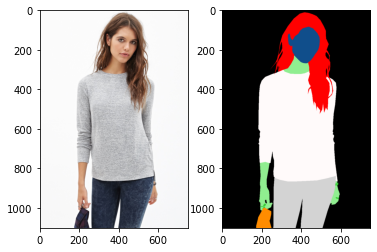

In [11]:
high_resolution_image = cv2.imread(full_body_img_df["high_resolution_name"].iloc[14])
high_resolution_segmentation_image = cv2.imread(full_body_img_df["high_resolution_segmentation_name"].iloc[14])
high_resolution_image_rgb = cv2.cvtColor(high_resolution_image, cv2.COLOR_BGR2RGB)
high_resolution_segmentation_image_rgb = cv2.cvtColor(high_resolution_segmentation_image, cv2.COLOR_BGR2RGB)
#high_resolution_segmentation_image_hsv = cv2.cvtColor(high_resolution_segmentation_image_rgb, cv2.COLOR_RGB2HSV)
plt.subplot(1, 2, 1)
plt.imshow(high_resolution_image_rgb)
plt.subplot(1, 2, 2)
plt.imshow(high_resolution_segmentation_image_rgb)
plt.show()

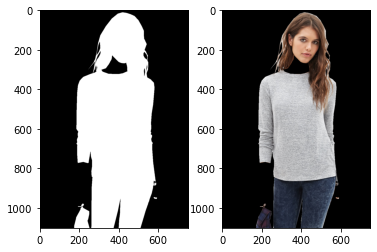

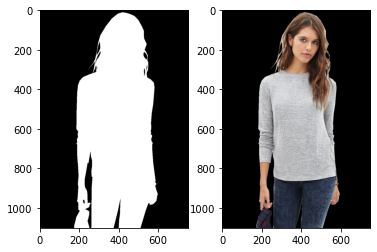

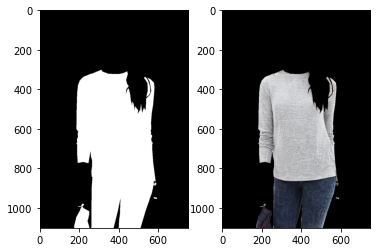

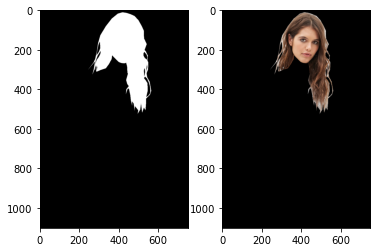

In [12]:
show_masks(high_resolution_image_rgb,high_resolution_segmentation_image_rgb)

In [24]:
full_body_img_df["high_resolution_name"].iloc[10]

'In-shop Clothes Retrieval Benchmark/Anno/Segmentation/img_highres_seg/WOMEN/Dresses/id_00000011/02_1_front.jpg'

Example 10


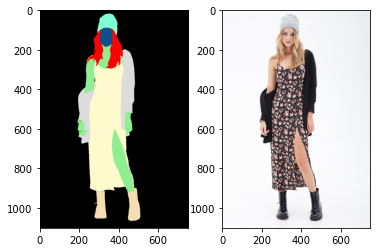

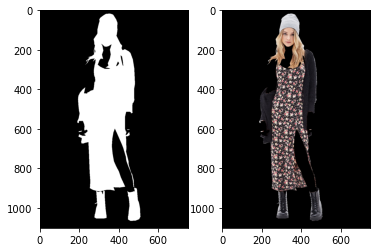

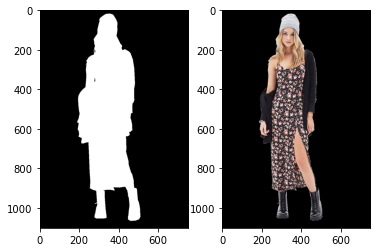

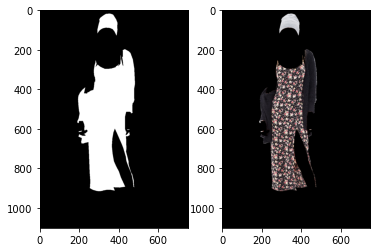

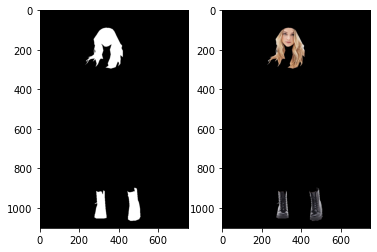

Example 11


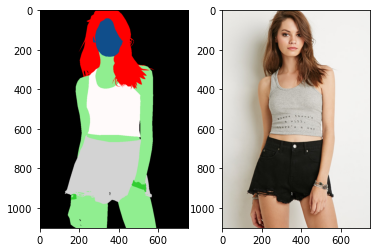

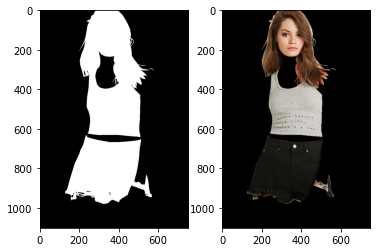

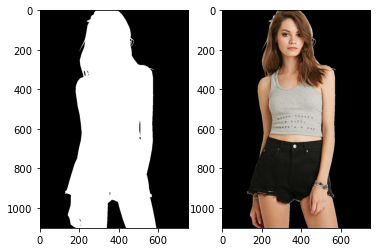

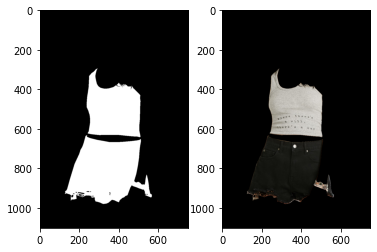

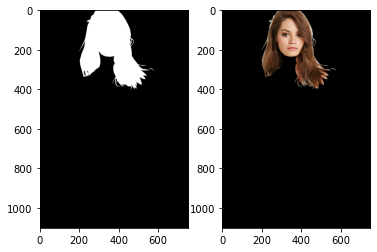

Example 12


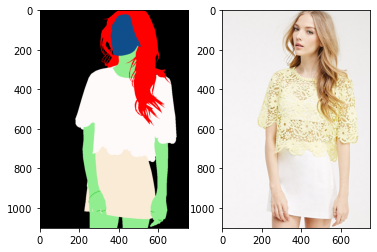

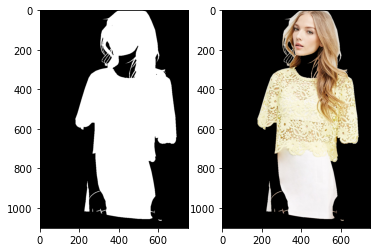

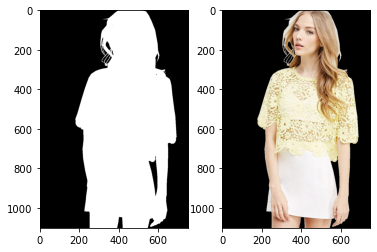

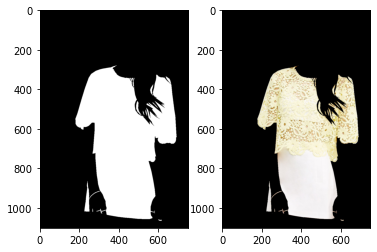

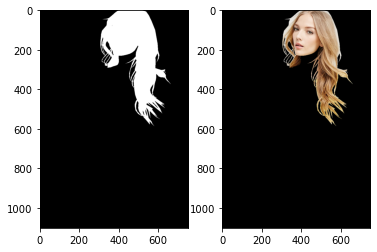

Example 13


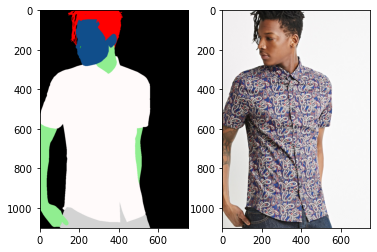

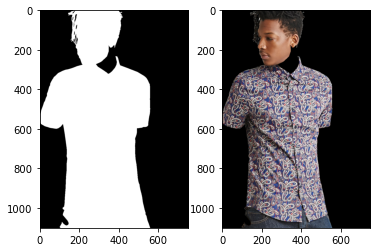

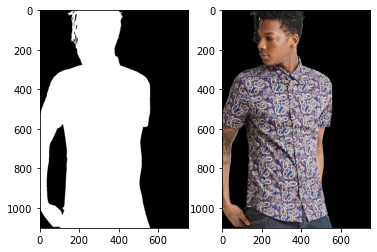

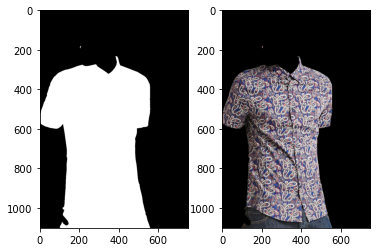

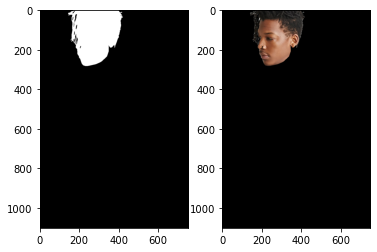

Example 14


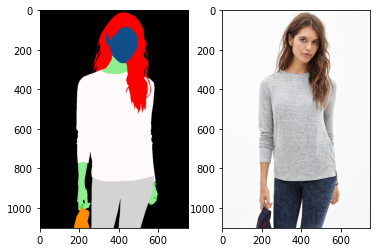

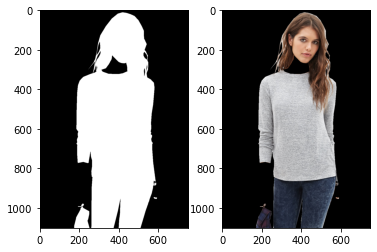

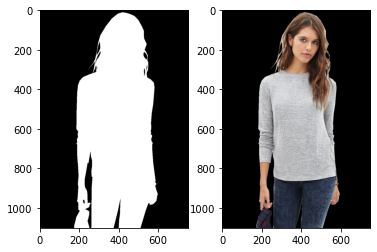

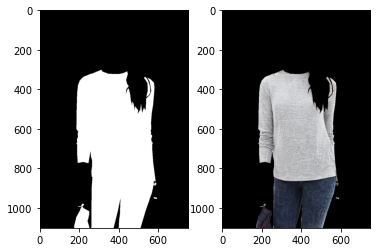

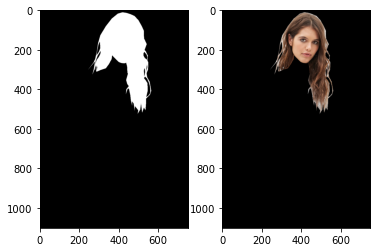

Example 15


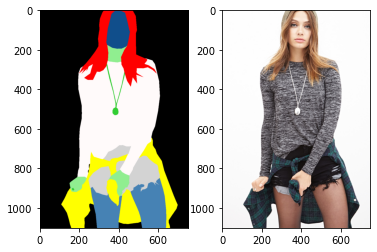

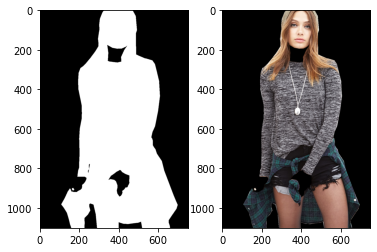

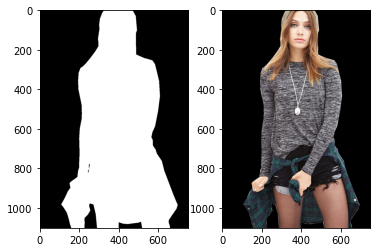

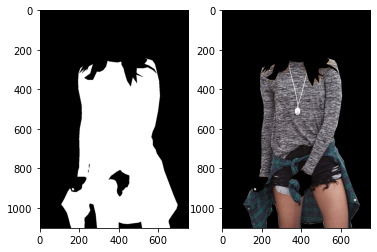

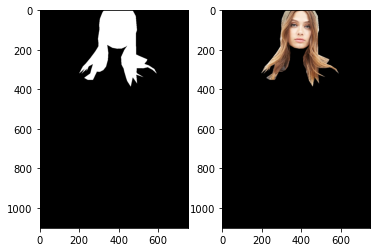

Example 16


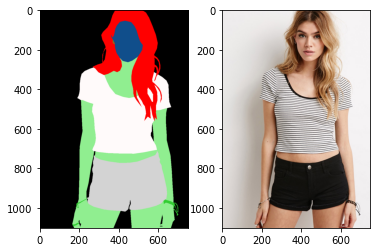

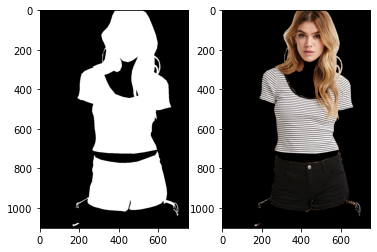

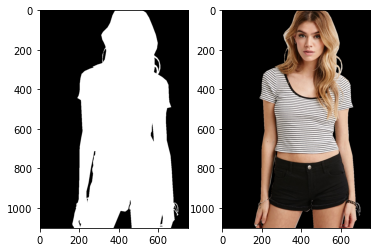

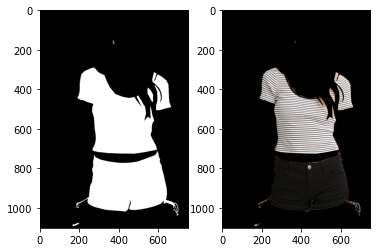

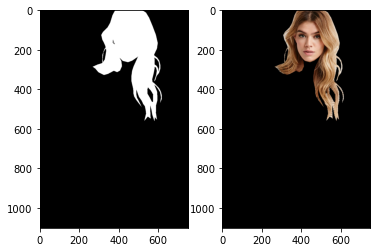

Example 17


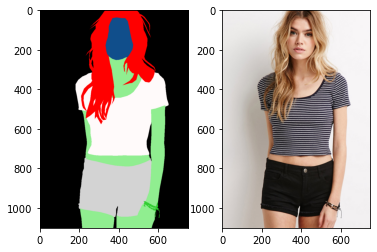

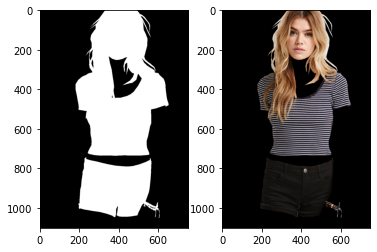

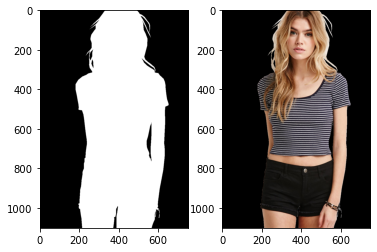

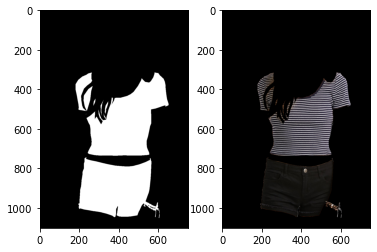

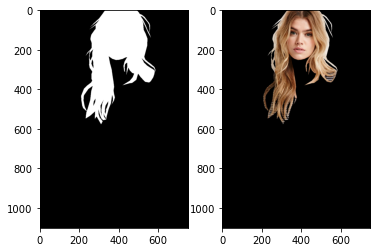

Example 18


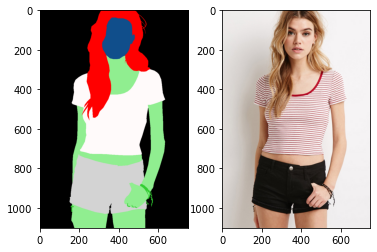

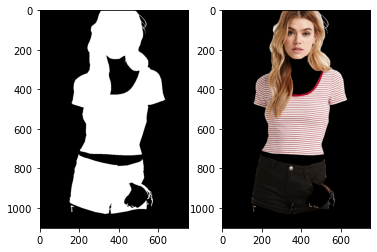

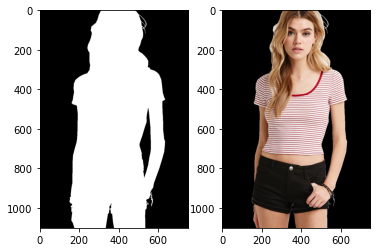

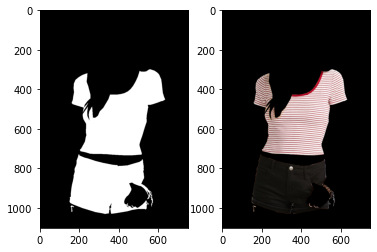

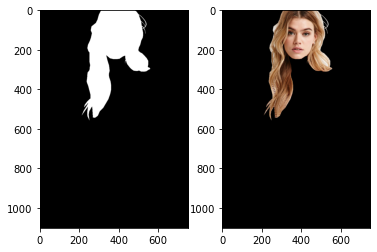

Example 19


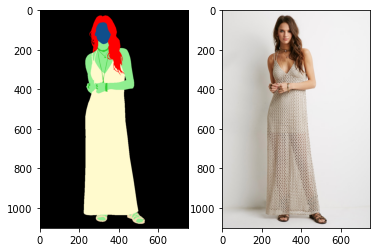

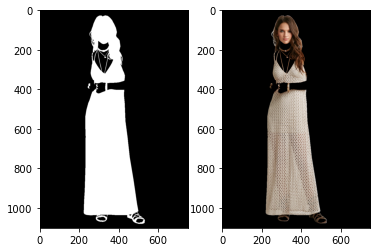

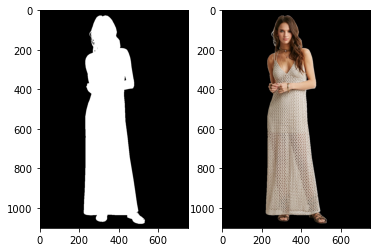

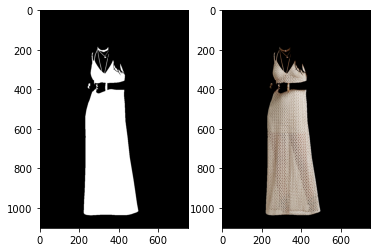

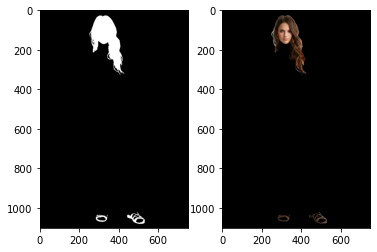

In [20]:
for i in range(10,20):
    print(f"Example {i}")
    high_resolution_image = cv2.imread(full_body_img_df["high_resolution_name"].iloc[i])
    high_resolution_segmentation_image = cv2.imread(full_body_img_df["high_resolution_segmentation_name"].iloc[i])
    high_resolution_image_rgb = cv2.cvtColor(high_resolution_image, cv2.COLOR_BGR2RGB)
    high_resolution_segmentation_image_rgb = cv2.cvtColor(high_resolution_segmentation_image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 1)
    plt.imshow(high_resolution_segmentation_image_rgb)
    plt.subplot(1, 2, 2)
    plt.imshow(high_resolution_image_rgb)
    plt.show()
    show_masks(high_resolution_image_rgb,high_resolution_segmentation_image_rgb)

### check pose

In [15]:
def get_pose_type(seg_img_rgb):
    head_mask, footwear_mask, skin_mask, apparel_mask, background_mask = create_masks(seg_img_rgb)
    if np.count_nonzero(head_mask):
        if np.count_nonzero(footwear_mask):
            return "full_body"
        else :
            return "upper_body"
    else : 
        return "no_body"
    
high_resolution_segmentation_image = cv2.imread(full_body_img_df["high_resolution_segmentation_name"].iloc[14])
high_resolution_segmentation_image_rgb = cv2.cvtColor(high_resolution_segmentation_image, cv2.COLOR_BGR2RGB)
get_pose_type(high_resolution_segmentation_image_rgb)

'upper_body'

In [16]:
def counter_pose():
    pose_counter = {}
    for i in tqdm(range(len(full_body_img_df["high_resolution_name"]))):
        #print(f"Example {i}")
        high_resolution_image = cv2.imread(full_body_img_df["high_resolution_name"].iloc[i])
        high_resolution_segmentation_image = cv2.imread(full_body_img_df["high_resolution_segmentation_name"].iloc[i])
        high_resolution_image_rgb = cv2.cvtColor(high_resolution_image, cv2.COLOR_BGR2RGB)
        high_resolution_segmentation_image_rgb = cv2.cvtColor(high_resolution_segmentation_image, cv2.COLOR_BGR2RGB)
        pose = get_pose_type(high_resolution_segmentation_image_rgb)
        pose_counter[pose] = 1 + pose_counter.get(pose,0)
    print(pose_counter)

### resize

In [17]:
def resize_with_padding(img,desired_size=256,white=False):
    """
    resize the image while keeping image ratio by adding padding to get a square img
    """
    old_size = img.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    img = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    if white:
        color = [256, 256, 256]
    else:
        color = [0,0,0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return new_img

### create dataset

In [18]:
def save_masked_resized_img(img,chosen_mask,quality,path,white=False):
    if chosen_mask is not None :
        img = cv2.bitwise_and(img, img, mask=chosen_mask)
    result_resized = resize_with_padding(img,desired_size=quality,white=white)
    results = cv2.imwrite(path,result_resized)

In [47]:
n = len(full_body_img_df)
full_body_count = 0
upper_body_count = 0
quality = 256

for i in tqdm(range(n)):
    # get img
    high_resolution_image_image = cv2.imread(full_body_img_df["high_resolution_name"].iloc[i])
    high_resolution_segmentation_image = cv2.imread(full_body_img_df["high_resolution_segmentation_name"].iloc[i])
    # get img in rgb 
    high_resolution_image_rgb = cv2.cvtColor(high_resolution_image, cv2.COLOR_BGR2RGB)
    high_resolution_segmentation_image_rgb = cv2.cvtColor(high_resolution_segmentation_image, cv2.COLOR_BGR2RGB)
    # check pose type
    pose_type = get_pose_type(high_resolution_segmentation_image_rgb)
    if pose_type == "no_body":
        continue
    elif pose_type == "full_body":
        full_body_count += 1 
        count = full_body_count 
    elif pose_type == "upper_body":
        upper_body_count += 1 
        count = upper_body_count 
    # create dir if not exist 
    pathlib.Path(f'data/{quality}/{pose_type}/{count}').mkdir(parents=True, exist_ok=True) 
    # get img with specific masks :
    head_mask, footwear_mask, skin_mask, apparel_mask, background_mask = create_masks(high_resolution_segmentation_image_rgb)
    
    # without skin ( save mask and image segmented ) 
    chosen_mask = head_mask + footwear_mask + apparel_mask
    # save_masked_resized_img(high_resolution_image_image,chosen_mask,quality,f'data/{quality}/{pose_type}/{count}/apparel_head_foot.jpg')
    save_masked_resized_img(chosen_mask,None,quality,f'data/{quality}/{pose_type}/{count}/segmentation_without_skin.jpg')
    
    #apparel
    chosen_mask = apparel_mask
    #save_masked_resized_img(high_resolution_image_image,chosen_mask,quality,f'data/{quality}/{pose_type}/{count}/apparel.jpg')
    
    # head_foot
    chosen_mask = head_mask + footwear_mask
    #save_masked_resized_img(high_resolution_image_image,chosen_mask,quality,f'data/{quality}/{pose_type}/{count}/head_foot.jpg')
    
    # with skin
    chosen_mask = head_mask + footwear_mask + skin_mask + apparel_mask
    #save_masked_resized_img(high_resolution_image_image,chosen_mask,quality,f'data/{quality}/{pose_type}/{count}/body.jpg')
    
    # save segmentation map 
    #save_masked_resized_img(high_resolution_segmentation_image,None,quality,f'data/{quality}/{pose_type}/{count}/segmentation_total.jpg')
    
    # save skin mask
    #save_masked_resized_img(skin_mask,None,quality,f'data/{quality}/{pose_type}/{count}/segmentation_skin.jpg')
    
    # save skin + background mask
    chosen_mask = skin_mask + background_mask
    save_masked_resized_img(chosen_mask,None,quality,f'data/{quality}/{pose_type}/{count}/segmentation_skin_background.jpg',white=True)

  0%|          | 0/7379 [00:00<?, ?it/s]